# YOLOv3 Detection

## Imports

In [1]:
import sys
import xir
import vart
import time
from typing import List
import random

import cv2
import importlib
import numpy as np
import matplotlib.pyplot as plt

## Utils

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class YOLOPost:
    def __init__(self, anchors, num_classes, img_size):
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.bbox_attrs = 5 + num_classes
        self.img_size = img_size

    def forward(self, input, targets=None):
        bs = input.shape[0]
        in_h = input.shape[2]
        in_w = input.shape[3]
        stride_h = self.img_size[1] / in_h
        stride_w = self.img_size[0] / in_w

        scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in self.anchors]

        prediction = input.reshape(bs, self.num_anchors, self.bbox_attrs, in_h, in_w).transpose(0, 1, 3, 4, 2)

        x = sigmoid(prediction[..., 0])
        y = sigmoid(prediction[..., 1])
        w = prediction[..., 2]
        h = prediction[..., 3]
        conf = sigmoid(prediction[..., 4])
        pred_cls = sigmoid(prediction[..., 5:])

        grid_x = np.tile(np.tile(np.linspace(0, in_w - 1, in_w), (in_w, 1)),
                         (bs * self.num_anchors, 1, 1)).reshape(x.shape)
        grid_y = np.tile(np.tile(np.linspace(0, in_h - 1, in_h), (in_h, 1)).T,
                         (bs * self.num_anchors, 1, 1)).reshape(y.shape)

        anchor_w = np.array(scaled_anchors)[:, 0].reshape(1, self.num_anchors, 1, 1)
        anchor_h = np.array(scaled_anchors)[:, 1].reshape(1, self.num_anchors, 1, 1)
        anchor_w = np.tile(anchor_w, (bs, 1, in_h, in_w))
        anchor_h = np.tile(anchor_h, (bs, 1, in_h, in_w))

        pred_boxes = np.empty_like(prediction[..., :4])
        pred_boxes[..., 0] = x + grid_x
        pred_boxes[..., 1] = y + grid_y
        pred_boxes[..., 2] = np.exp(w) * anchor_w
        pred_boxes[..., 3] = np.exp(h) * anchor_h

        _scale = np.array([stride_w, stride_h] * 2)

        output = np.concatenate((
            (pred_boxes.reshape(bs, -1, 4) * _scale),
            conf.reshape(bs, -1, 1),
            pred_cls.reshape(bs, -1, self.num_classes)
        ), axis=-1)

        return output

def bbox_iou(box1, box2, x1y1x2y2=True):
    if not x1y1x2y2:
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_rect_x1 = np.maximum(b1_x1, b2_x1)
    inter_rect_y1 = np.maximum(b1_y1, b2_y1)
    inter_rect_x2 = np.minimum(b1_x2, b2_x2)
    inter_rect_y2 = np.minimum(b1_y2, b2_y2)

    inter_area = np.maximum(0, inter_rect_x2 - inter_rect_x1 + 1) * \
                 np.maximum(0, inter_rect_y2 - inter_rect_y1 + 1)

    b1_area = abs((b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1))
    b2_area = abs((b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1))

    return inter_area / (b1_area + b2_area - inter_area + 1e-16)


def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    box_corner = np.copy(prediction)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]

    for image_i, image_pred in enumerate(prediction):
        conf_mask = (image_pred[:, 4] >= conf_thres)
        image_pred = image_pred[conf_mask]
        if not image_pred.shape[0]:
            continue

        class_conf = np.max(image_pred[:, 5:5 + num_classes], axis=1, keepdims=True)
        class_pred = np.argmax(image_pred[:, 5:5 + num_classes], axis=1)[:, np.newaxis]

        detections = np.concatenate((image_pred[:, :5],
                                     class_conf.astype(np.float32),
                                     class_pred.astype(np.float32)), axis=1)

        unique_labels = np.unique(detections[:, -1])

        for c in unique_labels:
            detections_class = detections[detections[:, -1] == c]
            conf_sort_index = np.argsort(detections_class[:, 4])[::-1]
            detections_class = detections_class[conf_sort_index]

            max_detections = []
            while detections_class.shape[0]:
                max_detections.append(detections_class[0].reshape(1, -1))
                if detections_class.shape[0] == 1:
                    break
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                keep_indices = np.where(ious < nms_thres)[0]
                detections_class = detections_class[1:][keep_indices]

            max_detections = np.concatenate(max_detections, axis=0)
            if output[image_i] is None:
                output[image_i] = max_detections
            else:
                output[image_i] = np.concatenate((output[image_i], max_detections), axis=0)

    return output


## Inference

In [3]:
def runYolo(dpu_runner_tfYolo, image, config, image_path):
    inputTensors = dpu_runner_tfYolo.get_input_tensors()
    outputTensors = dpu_runner_tfYolo.get_output_tensors()

    output_sizes = [(t.dims[1], t.dims[2], t.dims[3]) for t in outputTensors]

    runSize = 1
    shapeIn = (runSize,) + tuple([inputTensors[0].dims[i] for i in range(inputTensors[0].ndim)][1:])

    outputData = [np.empty((runSize, h, w, c), dtype=np.float32, order='C') for h, w, c in output_sizes]
    inputData = [np.empty(shapeIn, dtype=np.float32, order='C')]

    inputData[0][0, ...] = image.reshape(inputTensors[0].dims[1],
                                         inputTensors[0].dims[2],
                                         inputTensors[0].dims[3])

    job_id = dpu_runner_tfYolo.execute_async(inputData, outputData)
    dpu_runner_tfYolo.wait(job_id)

    outputData = [np.transpose(o, (0, 3, 1, 2)) for o in outputData]

    yolo_losses = [YOLOPost(config["yolo"]["anchors"][i],
                            config["yolo"]["classes"],
                            (config["img_w"], config["img_h"])) for i in range(3)]

    output_list = [yolo_losses[i].forward(outputData[i]) for i in range(3)]
    output_con = np.concatenate(output_list, 1)

    batch_detections = non_max_suppression(output_con,
                                           config["yolo"]["classes"],
                                           conf_thres=config["confidence_threshold"],
                                           nms_thres=0.45)

    classes = open(config["classes_names_path"], "r").read().split("\n")[:-1]

    # Wczytaj oryginalny obraz (będzie zapisany zawsze)
    im = cv2.imread(image_path)

    for detections in batch_detections:
        if detections is not None:
            unique_labels = np.unique(detections[:, -1])
            bbox_colors = {int(cls_pred): (random.randint(0, 255),
                                           random.randint(0, 255),
                                           random.randint(0, 255)) for cls_pred in unique_labels}

            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                color = bbox_colors[int(cls_pred)]
                ori_h, ori_w, _ = im.shape
                pre_h, pre_w = config["img_h"], config["img_w"]
                box_h = ((y2 - y1) / pre_h) * ori_h
                box_w = ((x2 - x1) / pre_w) * ori_w
                y1 = (y1 / pre_h) * ori_h
                x1 = (x1 / pre_w) * ori_w

                cv2.rectangle(im, (int(x1), int(y1)), (int(x1 + box_w), int(y1 + box_h)), color, 2)
                label = f"{classes[int(cls_pred)]} {conf:.2f}"
                cv2.putText(im, label, (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    output_path = "prediction.jpg"
    success = cv2.imwrite(output_path, im)
    if success:
        print(f"Prediction saved as {output_path}")
    else:
        print(f"Failed to save prediction to {output_path}")

    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.show()



def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    root_subgraph = graph.get_root_subgraph()
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    return [cs for cs in child_subgraphs if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"]


def camera_inference(xmodel_file, cam_id=0, cam_width=640, cam_height=480, display_scale=0.75):
    g = xir.Graph.deserialize(xmodel_file)
    subgraphs = get_child_subgraph_dpu(g)
    assert len(subgraphs) == 1

    dpu_runners = vart.Runner.create_runner(subgraphs[0], "run")

    params_path = "params.py"
    config = importlib.import_module(params_path[:-3]).TRAINING_PARAMS
    classes = open(config["classes_names_path"], "r").read().split("\n")[:-1]

    cap = cv2.VideoCapture(cam_id)
    if not cap.isOpened():
        print(f"Failed to open camera {cam_id}")
        return

    # Set lower resolution for faster processing
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, cam_width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, cam_height)

    print("Camera started. Press 'q' to exit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame from camera")
            break

        # Prepare image for YOLO
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, (config["img_w"], config["img_h"]), interpolation=cv2.INTER_LINEAR)
        image_resized = image_resized.astype(np.float32) / 255.0

        # --- inference ---
        inputTensors = dpu_runners.get_input_tensors()
        outputTensors = dpu_runners.get_output_tensors()
        output_sizes = [(t.dims[1], t.dims[2], t.dims[3]) for t in outputTensors]
        runSize = 1
        shapeIn = (runSize,) + tuple([inputTensors[0].dims[i] for i in range(inputTensors[0].ndim)][1:])
        outputData = [np.empty((runSize, h, w, c), dtype=np.float32, order='C') for h, w, c in output_sizes]
        inputData = [np.empty(shapeIn, dtype=np.float32, order='C')]

        inputData[0][0, ...] = image_resized.reshape(inputTensors[0].dims[1],
                                                     inputTensors[0].dims[2],
                                                     inputTensors[0].dims[3])

        job_id = dpu_runners.execute_async(inputData, outputData)
        dpu_runners.wait(job_id)
        outputData = [np.transpose(o, (0, 3, 1, 2)) for o in outputData]

        # --- postprocessing ---
        yolo_losses = [YOLOPost(config["yolo"]["anchors"][i],
                                config["yolo"]["classes"],
                                (config["img_w"], config["img_h"])) for i in range(3)]
        output_list = [yolo_losses[i].forward(outputData[i]) for i in range(3)]
        output_con = np.concatenate(output_list, 1)

        batch_detections = non_max_suppression(output_con,
                                               config["yolo"]["classes"],
                                               conf_thres=config["confidence_threshold"],
                                               nms_thres=0.45)

        detections = batch_detections[0]
        if detections is not None:
            unique_labels = np.unique(detections[:, -1])
            bbox_colors = {int(cls_pred): (random.randint(0, 255),
                                           random.randint(0, 255),
                                           random.randint(0, 255)) for cls_pred in unique_labels}
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                color = bbox_colors[int(cls_pred)]
                ori_h, ori_w, _ = frame.shape
                pre_h, pre_w = config["img_h"], config["img_w"]
                box_h = ((y2 - y1) / pre_h) * ori_h
                box_w = ((x2 - x1) / pre_w) * ori_w
                y1 = (y1 / pre_h) * ori_h
                x1 = (x1 / pre_w) * ori_w
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x1 + box_w), int(y1 + box_h)), color, 2)
                label = f"{classes[int(cls_pred)]} {conf:.2f}"
                cv2.putText(frame, label, (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Resize displayed frame if needed
        if display_scale != 1.0:
            frame = cv2.resize(frame, (0, 0), fx=display_scale, fy=display_scale)

        cv2.imshow("YOLO Camera", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    del dpu_runners


def main(xmodel_file, image_path):
    g = xir.Graph.deserialize(xmodel_file)
    subgraphs = get_child_subgraph_dpu(g)
    assert len(subgraphs) == 1

    dpu_runners = vart.Runner.create_runner(subgraphs[0], "run")

    params_path = "params.py"
    config = importlib.import_module(params_path[:-3]).TRAINING_PARAMS

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (config["img_w"], config["img_h"]), interpolation=cv2.INTER_LINEAR)
    image = image.astype(np.float32) / 255.0

    time_start = time.time()
    runYolo(dpu_runners, image, config, image_path)
    time_end = time.time()
    del dpu_runners

    fps = 1.0 / (time_end - time_start)
    print(f"FPS={fps:.2f}, total frames = 1, time={time_end - time_start:.6f} seconds")


## Main

Prediction saved as prediction.jpg


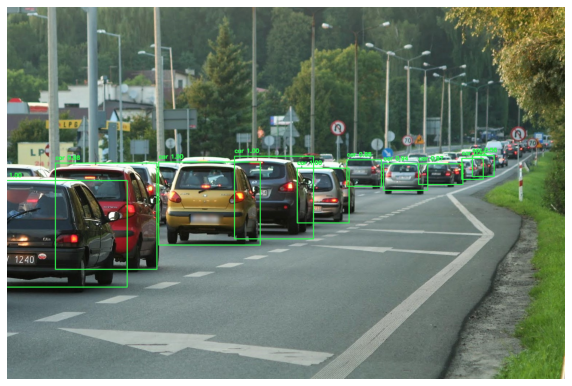

FPS=0.48, total frames = 1, time=2.063333 seconds


In [7]:
# Image
main("yolov3.xmodel", "5.jpg")

# Camera
#camera_inference("yolov3.xmodel", cam_id=0)